In [1]:
from word_vectorization import Word2Vec
import matplotlib.pyplot as plt
import tensorflow as tf

To-Do:
- Add printing functionality to state how many times the fit() method trained through the entire corpus.
- Calculate slope of the training curve and display with line on chart
- Check CBOW vs skipgram, and compare tp the original paper hyperparams
- Figure out optimizations (stemming, lematization, ??) -Adjust batch size? (Also, does each train loop pickup where the other left off? (use % len()))
- Fix 'fit_from_tokens' to match 'fit' output
- Clean wiki dataset by removing extra sections at the end (ie. see also, references)
- Test word2vec embeddings with wiki dataset
- Implement GloVe
- Test GloVe embeddings with wiki dataset
- Implement Intelligent Agent

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
with open(path_to_file) as f:
    words = [word for line in f.readlines() for word in line.split()]

print(f'Number of words: {len(words)}')
print(f'First 10 words: {words[:10]}')
print(f"Unique words in Shakespeare Corpus before pre-processing: {len(set(words))}")

Number of words: 202651
First 10 words: ['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.']
Unique words in Shakespeare Corpus before pre-processing: 25670



Tokenizing words...

Training model...


Training has completed successfully with a final loss of 0.6454790830612183.



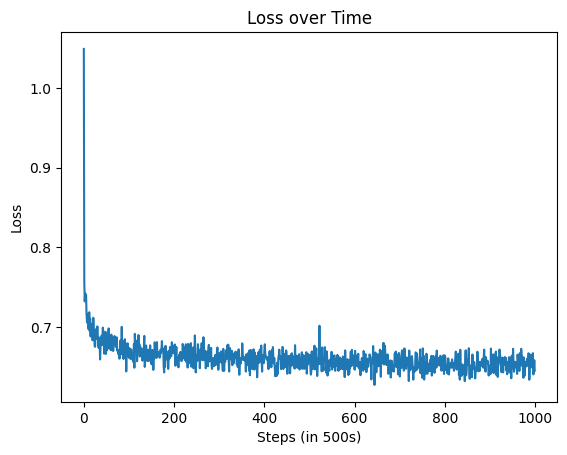


Embedding for 'king': [-3.82109880e-02  5.86841106e-02  2.72141770e-02 -3.71447876e-02
  5.17102098e-03  1.28101511e-02  8.75980929e-02  1.85777303e-02
  5.97779900e-02 -1.45109355e-01  9.90791693e-02  3.85087430e-02
  6.03056289e-02 -1.10173412e-01  6.31943196e-02  2.12050285e-02
  5.27648330e-02  1.40916824e-01 -9.81610455e-03 -1.04431160e-01
  1.73561405e-02  9.30048227e-02 -9.68357697e-02  1.25379533e-01
  1.06081687e-01 -2.93698050e-02 -1.04596205e-01  1.38476327e-01
 -6.90706149e-02  1.25367597e-01 -1.48127779e-01 -1.39650777e-01
 -1.22277379e-01  6.51253834e-02 -1.02298684e-01  1.16856612e-01
  4.22591530e-02  1.19987197e-01  8.88467133e-02  1.27794027e-01
 -1.13928306e-03 -2.26085279e-02  1.37888446e-01 -8.24995413e-02
 -6.60843179e-02  4.93788570e-02 -1.22202128e-01 -1.18713692e-01
 -2.56024282e-02  3.82884493e-04 -8.50482211e-02 -4.12133560e-02
 -8.40616506e-03  2.69492716e-02  1.01897851e-01  1.25007825e-02
 -1.19575009e-01 -1.09716326e-01  9.35934205e-03 -9.91350636e-02
  

In [3]:
test_model = Word2Vec(architecture='skipgram', batch_size=1000, num_skips=8, skip_window=5, vocab_size=12000, n_steps=500001)
loss_values = test_model.fit(words)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Steps (in 500s)')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

test_model.eval()


In [ ]:
pickle_file_path = 'Resources\\corpus.pkl'
batch_size = 128
num_skips = 4
skip_window = 2

word2vec = Word2Vec(architecture='cbow', batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
model = word2vec.fit(pickle_file_path)